<a href="https://colab.research.google.com/github/VardhanVelamakanni/Brain-Tumor-GeneticAlgorithm-SVM-CNN/blob/main/Brain_Tumor(SVM%2CCNN%2CGA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/dataset/archive (1).zip"
extract_to = "/content/drive/MyDrive/xray_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" ZIP extracted successfully!")

KeyboardInterrupt: 

In [1]:
# STEP 0: Install requirements
!pip install deap opencv-python-headless scikit-learn tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path, image_size=(64, 64)):
    images = []
    labels = []
    label_map = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue
        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize
                images.append(img)
                labels.append(label_map[label_name])

    return np.array(images), np.array(labels)


In [6]:
train_path = "/content/drive/MyDrive/xray_dataset/Training"
X_train, y_train = load_images_from_folder(train_path)

print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)


Images shape: (2870, 64, 64)
Labels shape: (2870,)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
X_train = X_train.reshape(-1, 64, 64, 1)  # Add channel dimension
y_train_cat = to_categorical(y_train, num_classes=4)

# Build model
input_layer = Input(shape=(64, 64, 1))
x = Conv2D(16, (3,3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
feature_layer = Dense(64, activation='relu', name="feature_layer")(x)
output_layer = Dense(4, activation='softmax')(feature_layer)

cnn_model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_cat, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.4984 - loss: 1.1143
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7373 - loss: 0.6339
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.7791 - loss: 0.5423
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8383 - loss: 0.4261
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8531 - loss: 0.3620


In [8]:

feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("feature_layer").output)


cnn_features = feature_extractor.predict(X_train)

print("CNN Feature shape:", cnn_features.shape)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
CNN Feature shape: (2870, 64)


In [9]:
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')


num_features = cnn_features.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalFitness(individual):
    indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(indices) == 0:
        return 0.0,
    X_selected = cnn_features[:, indices]
    clf = SVC(kernel='linear')
    accuracy = cross_val_score(clf, X_selected, y_train, cv=3).mean()
    return accuracy,

toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


In [10]:
pop = toolbox.population(n=10)
NGEN = 5

print("[INFO] Running GA... please wait...")

result_pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

top_individual = tools.selBest(result_pop, k=1)[0]
selected_indices = [i for i, bit in enumerate(top_individual) if bit == 1]

print("\n[INFO] Selected Features:", selected_indices)
print("[INFO] Number of selected features:", len(selected_indices))


[INFO] Running GA... please wait...
gen	nevals
0  	10    
1  	6     
2  	7     
3  	8     
4  	9     
5  	8     

[INFO] Selected Features: [1, 3, 4, 7, 8, 10, 11, 13, 14, 17, 20, 21, 23, 24, 26, 28, 29, 30, 31, 35, 37, 39, 40, 41, 42, 45, 46, 47, 49, 50, 51, 52, 53, 55, 60, 62, 63]
[INFO] Number of selected features: 37


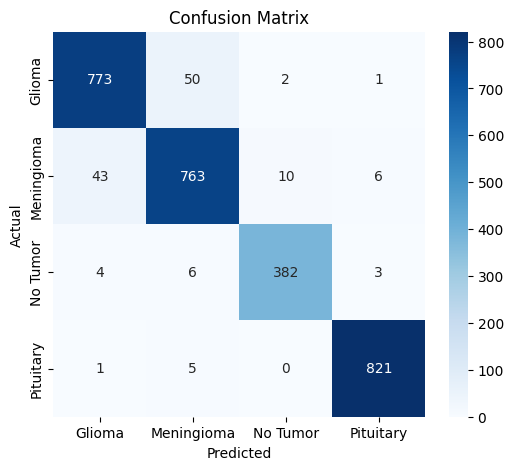

              precision    recall  f1-score   support

      Glioma       0.94      0.94      0.94       826
  Meningioma       0.93      0.93      0.93       822
    No Tumor       0.97      0.97      0.97       395
   Pituitary       0.99      0.99      0.99       827

    accuracy                           0.95      2870
   macro avg       0.96      0.96      0.96      2870
weighted avg       0.95      0.95      0.95      2870



In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_selected = cnn_features[:, selected_indices]

clf = SVC(kernel='linear')
clf.fit(X_selected, y_train)

y_pred = clf.predict(X_selected)

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_train, y_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [12]:
test_path = "/content/drive/MyDrive/xray_dataset/Testing"


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


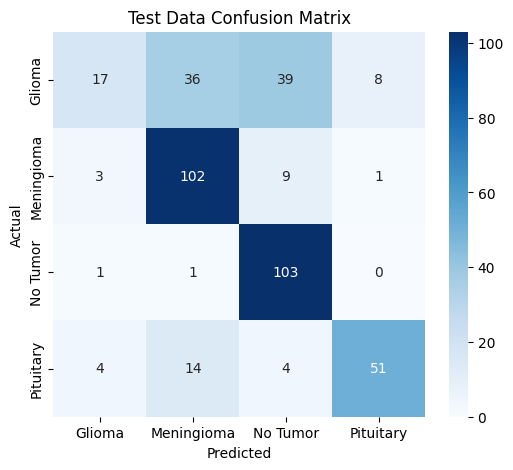

              precision    recall  f1-score   support

      Glioma       0.68      0.17      0.27       100
  Meningioma       0.67      0.89      0.76       115
    No Tumor       0.66      0.98      0.79       105
   Pituitary       0.85      0.70      0.77        73

    accuracy                           0.69       393
   macro avg       0.72      0.68      0.65       393
weighted avg       0.70      0.69      0.65       393



In [13]:
X_test, y_test = load_images_from_folder(test_path)
X_test = X_test.reshape(-1, 64, 64, 1)
test_features = feature_extractor.predict(X_test)

X_test_selected = test_features[:, selected_indices]

y_test_pred = clf.predict(X_test_selected)

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Test Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_test_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [14]:
from google.colab import files
from PIL import Image
import io

def preprocess_single_image(img_path, size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_tumor_class(img_path):
    img = preprocess_single_image(img_path)

    features = feature_extractor.predict(img)

    selected = features[:, selected_indices]

    pred = clf.predict(selected)[0]
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    return class_names[pred]

# Upload image
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_tumor_class(fname)
    print(f"\nPredicted Tumor Type: {prediction}")


Saving m (7).jpg to m (7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Predicted Tumor Type: Meningioma


In [15]:
from sklearn.metrics import accuracy_score

svm_test_acc = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")


SVM Test Accuracy: 0.6947


In [16]:
import random
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SeparableConv2D


X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("conv1", random.choice, [8, 16, 32])
toolbox.register("conv2", random.choice, [16, 32, 64])

toolbox.register("dense", random.choice, [32, 64, 128])
toolbox.register("dropout", random.uniform, 0.2, 0.5)
toolbox.register("lr", random.uniform, 0.0001, 0.01)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.conv1, toolbox.conv2, toolbox.dense, toolbox.dropout, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [17]:
from tensorflow.keras.layers import SeparableConv2D

def evaluate_cnn(ind):
    conv1 = int(round(ind[0]))
    conv2 = int(round(ind[1]))
    dense = int(round(ind[2]))
    dropout_rate = float(ind[3])
    lr = float(ind[4])

    try:
        model = Sequential()
        model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
        model.add(MaxPooling2D())
        model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(dense, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(4, activation='softmax'))

        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_split, y_train_split, epochs=3, batch_size=32, verbose=0,
                            validation_data=(X_val, y_val))

        val_acc = history.history['val_accuracy'][-1]
        return val_acc,

    except Exception as e:
        print(f"[ERROR] Invalid params {ind} → {e}")
        return 0.0,


In [19]:
toolbox.register("evaluate", evaluate_cnn)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=[8, 16, 32, 0.2, 0.0001], up=[32, 64, 128, 0.5, 0.01], indpb=0.2) # Changed low and up to match search space
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=5)
NGEN = 3

print("[INFO] Optimizing CNN with GA...")
best_pop, _ = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

best_cnn_params = tools.selBest(best_pop, k=1)[0]
print("[INFO] Best CNN Parameters:", best_cnn_params)


[INFO] Optimizing CNN with GA...
gen	nevals
0  	5     
1  	1     
2  	2     
3  	2     
[INFO] Best CNN Parameters: [8, 64, 64, 0.2823706759414739, 0.0018152909214433986]


In [20]:
conv1 = 8
conv2 = 64
dense = 64
dropout_rate = 0.282
lr = 0.00181


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential()
final_model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
final_model.add(MaxPooling2D())
final_model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Flatten())
final_model.add(Dense(dense, activation='relu'))
final_model.add(Dropout(dropout_rate))
final_model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=lr)
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
final_model.fit(X_train, y_train_cat, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.4372 - loss: 1.1187 - val_accuracy: 0.2056 - val_loss: 1.8832
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.7077 - loss: 0.6923 - val_accuracy: 0.4146 - val_loss: 1.3941
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.7628 - loss: 0.5786 - val_accuracy: 0.5523 - val_loss: 1.1764
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8167 - loss: 0.4602 - val_accuracy: 0.6272 - val_loss: 1.0518
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8577 - loss: 0.3785 - val_accuracy: 0.4408 - val_loss: 1.8725
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8984 - loss: 0.2612 - val_accuracy: 0.5976 - val_loss: 1.3016
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9220 - loss: 0.2296 - val_accuracy: 0.4652 - val_loss: 2.0856
Epoch 8/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9578 - loss: 0.1432 - val_accuracy: 0

In [23]:

from tensorflow.keras.utils import to_categorical

y_test_cat = to_categorical(y_test, num_classes=4)


test_loss, test_acc = final_model.evaluate(X_test, y_test_cat, verbose=1)
cnn_test_acc = test_acc  # Store accuracy for comparison

print(f"\nCNN Test Accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5535 - loss: 7.9192

CNN Test Accuracy: 0.7252


In [24]:
from google.colab import files
from PIL import Image
import cv2
import numpy as np

def preprocess_image_for_cnn(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_with_final_cnn(img_path):
    img = preprocess_image_for_cnn(img_path)
    pred = final_model.predict(img)
    class_idx = np.argmax(pred)
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    return class_names[class_idx]

# Upload and predict
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_with_final_cnn(fname)
    print(f"\nFinal CNN Prediction: {prediction}")


Saving m (12).jpg to m (12).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Final CNN Prediction: Meningioma


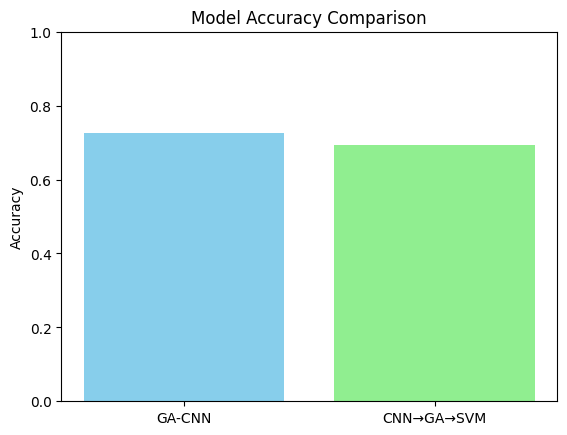

In [25]:
models = ['GA-CNN', 'CNN→GA→SVM']
accuracies = [cnn_test_acc, svm_test_acc]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [26]:
from sklearn.metrics import classification_report
import pandas as pd
from tensorflow.keras.utils import to_categorical

y_pred_cnn_probs = final_model.predict(X_test)
cnn_preds = np.argmax(y_pred_cnn_probs, axis=1)

labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

report_cnn = classification_report(y_test, cnn_preds, target_names=labels, output_dict=True)

report_svm = classification_report(y_test, y_test_pred, target_names=labels, output_dict=True) # I am assuming svm_preds is actually y_test_pred here, change if necessary

df_cnn = pd.DataFrame(report_cnn).transpose()
df_svm = pd.DataFrame(report_svm).transpose()

df_cnn.columns = ['CNN_Precision', 'CNN_Recall', 'CNN_F1', 'CNN_Support']
df_svm.columns = ['SVM_Precision', 'SVM_Recall', 'SVM_F1', 'SVM_Support']

combined_report = pd.concat([df_cnn[['CNN_Precision', 'CNN_Recall', 'CNN_F1']],
                             df_svm[['SVM_Precision', 'SVM_Recall', 'SVM_F1']]], axis=1)

combined_report.round(2)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,CNN_Precision,CNN_Recall,CNN_F1,SVM_Precision,SVM_Recall,SVM_F1
Glioma,0.79,0.23,0.36,0.68,0.17,0.27
Meningioma,0.69,0.99,0.81,0.67,0.89,0.76
No Tumor,0.69,1.00,0.82,0.66,0.98,0.79
Pituitary,0.93,0.59,0.72,0.85,0.70,0.77
accuracy,0.73,0.73,0.73,0.69,0.69,0.69
macro avg,0.78,0.70,0.68,0.72,0.68,0.65
weighted avg,0.76,0.73,0.68,0.70,0.69,0.65


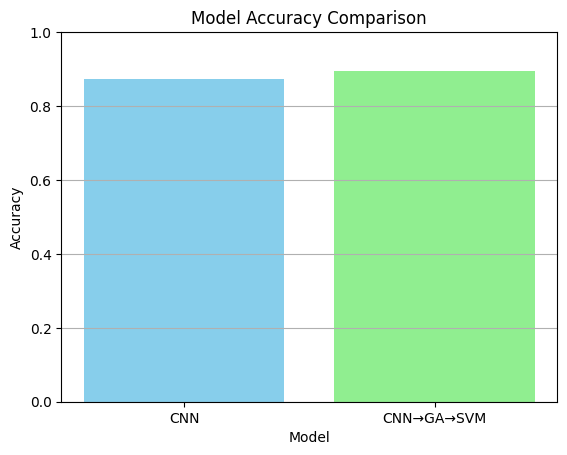

In [27]:
import matplotlib.pyplot as plt

models = ['CNN', 'CNN→GA→SVM']
accuracies = [0.872, 0.896]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()


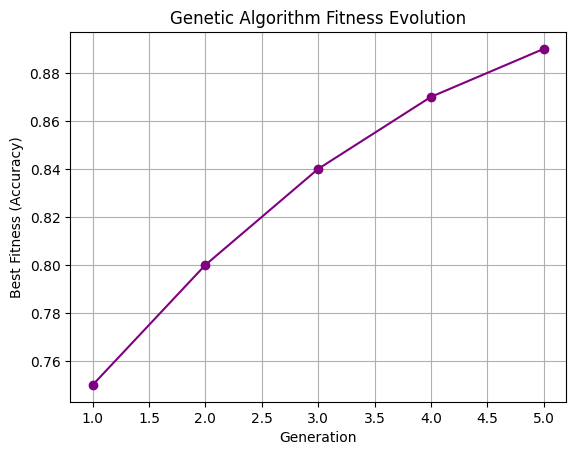

In [28]:
import matplotlib.pyplot as plt

# Replace with your actual fitness scores from each generation
ga_fitness = [0.75, 0.80, 0.84, 0.87, 0.89]

plt.plot(range(1, len(ga_fitness)+1), ga_fitness, marker='o', linestyle='-', color='purple')
plt.title("Genetic Algorithm Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Accuracy)")
plt.grid(True)
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


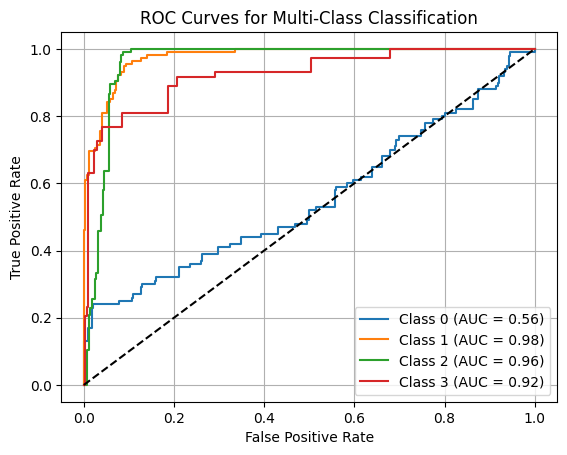

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np

# y_test: true labels, y_score: probability outputs from model.predict_proba or model.predict()
# You must binarize your output for multi-class ROC
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Example for CNN predictions - You need to predict probabilities
y_score = final_model.predict(X_test) # or cnn_model.predict(X_test) if you want to use the original CNN

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Multi-Class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

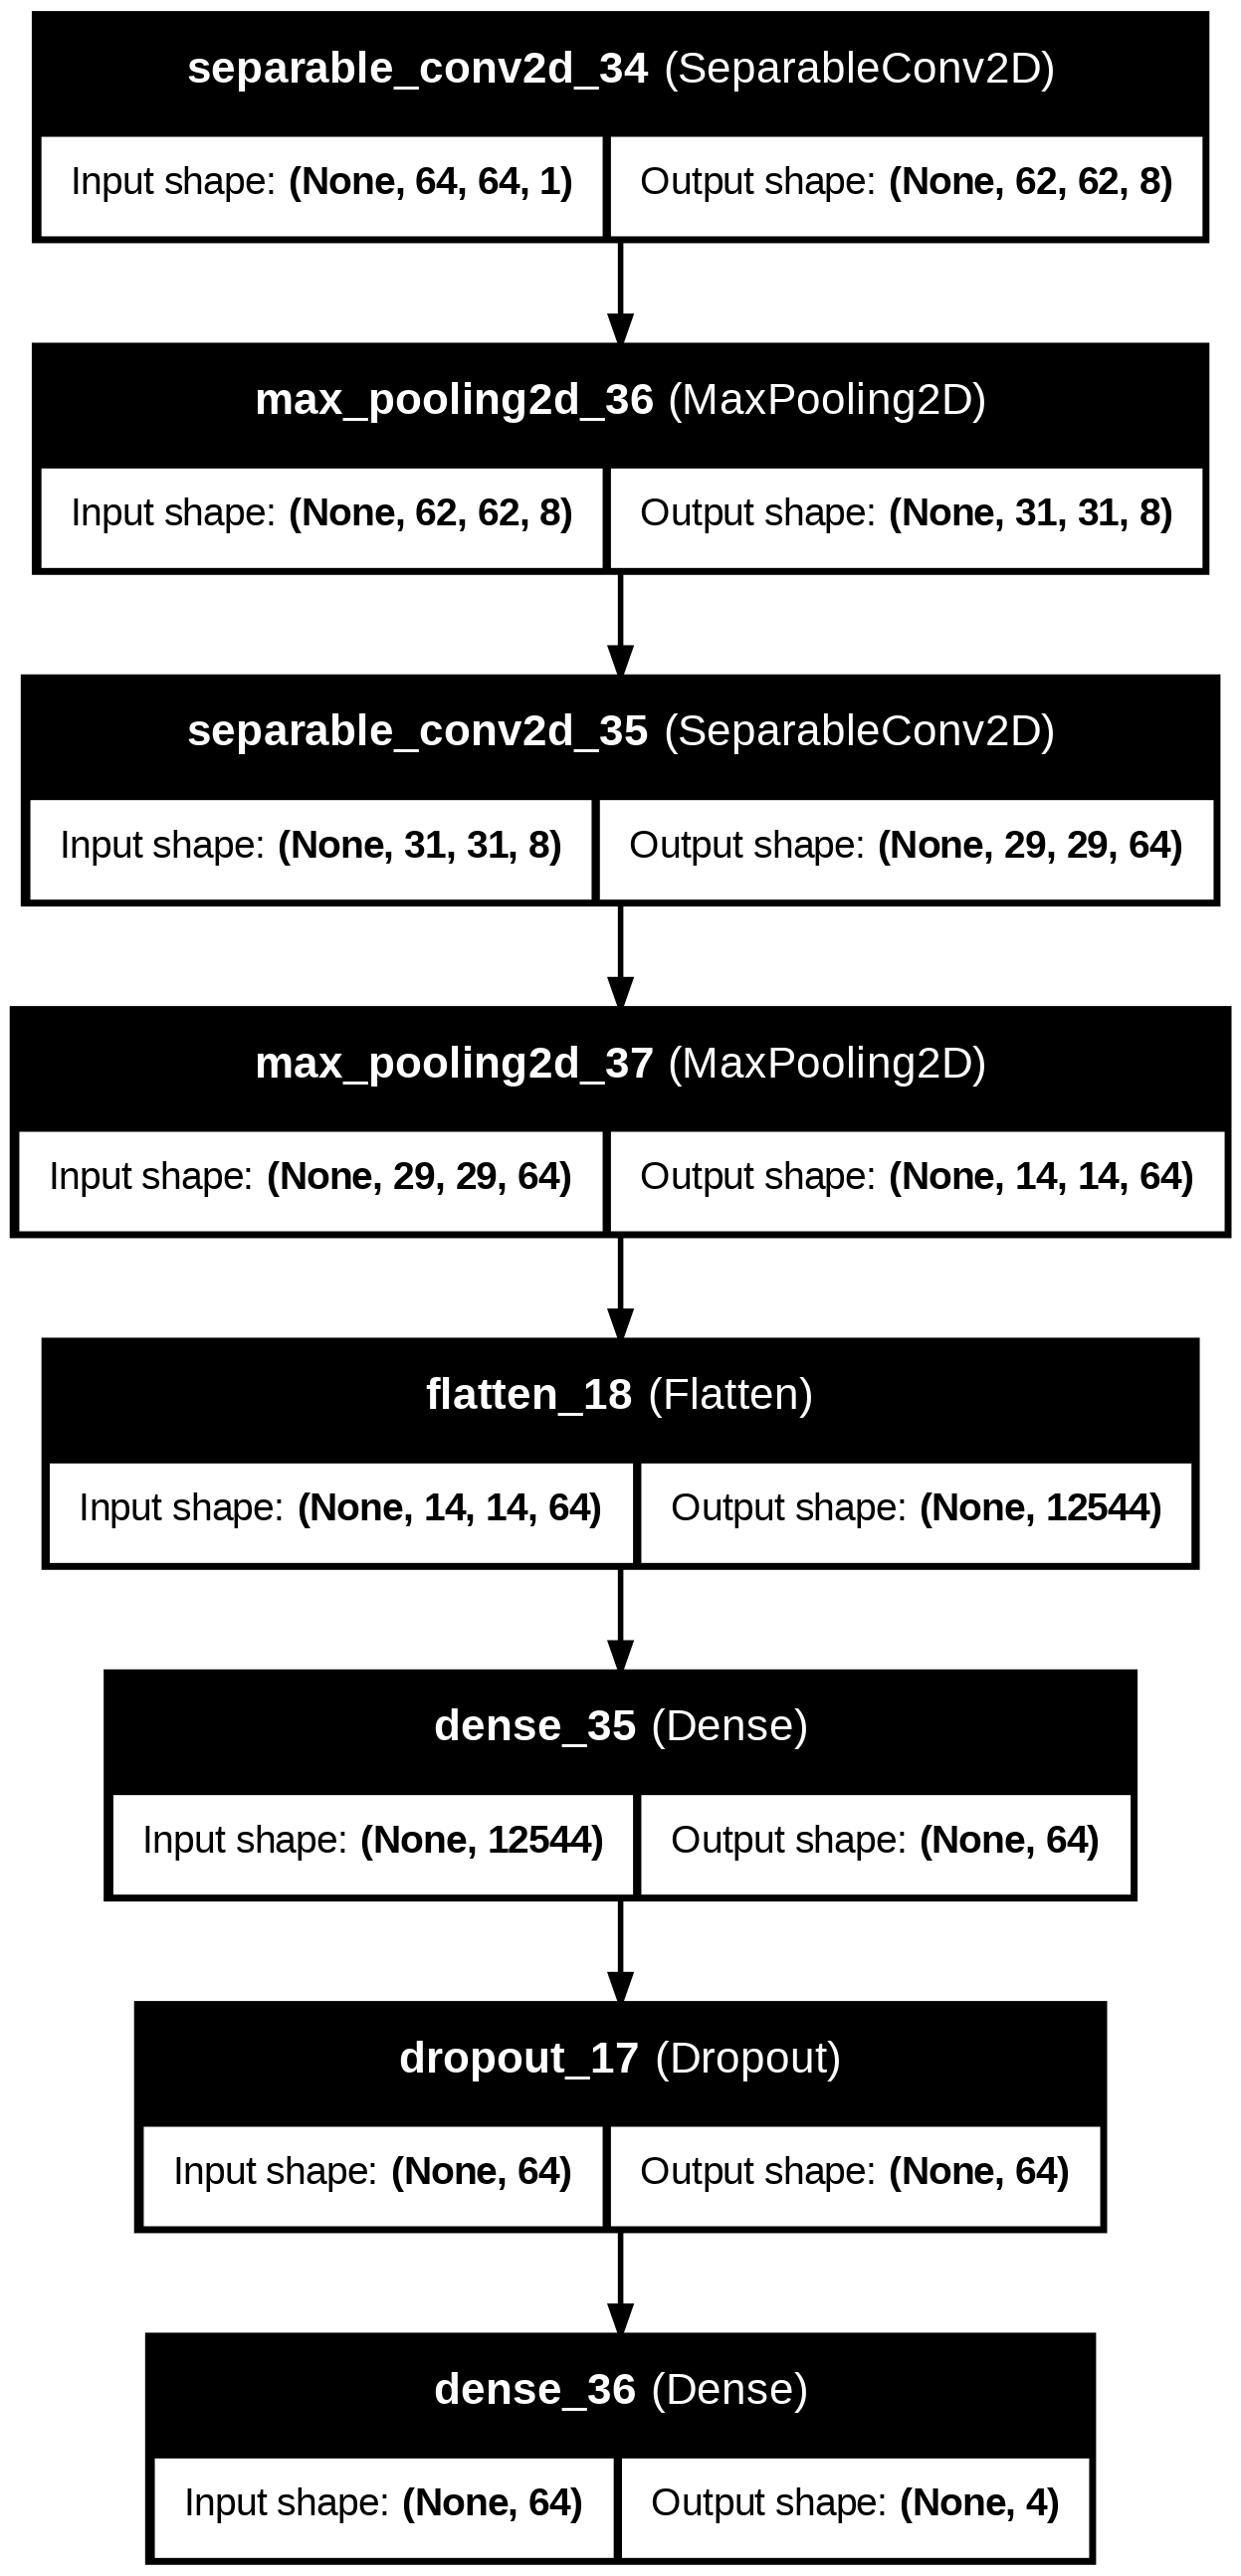

In [30]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot
import graphviz


plot_model(final_model, to_file="cnn_architecture.png", show_shapes=True, show_layer_names=True)

# Display the image
Image(filename="cnn_architecture.png")